In [1]:
import jax
import jax.numpy as jnp

example_trees = [
  [1, 'a', object()],
  (1, (2, 3), ()),
  [1, {'k1': 2, 'k2': (3, 4)}, 5],
  {'a': 2, 'b': (2, 3)},
  jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves = jax.tree_util.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7f99bf477d30>]   has 3 leaves: [1, 'a', <object object at 0x7f99bf477d30>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


2024-07-14 21:35:16.959935: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
list_of_lists = [
  [1, 2, 3],
  [1, 2],
  [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

/tmp/ipykernel_3589852/4068222104.py:7: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(lambda x: x*2, list_of_lists)


[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

In [3]:
jax.tree_map(lambda x, y: x+y, list_of_lists, list_of_lists)

/tmp/ipykernel_3589852/2433898325.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(lambda x, y: x+y, list_of_lists, list_of_lists)


[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

In [4]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

In [5]:
import os

os.environ['XLA_FLAGS']

'--xla_gpu_cuda_data_dir=/usr/local/cuda-12.1'

/tmp/ipykernel_3589852/4274648841.py:23: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(


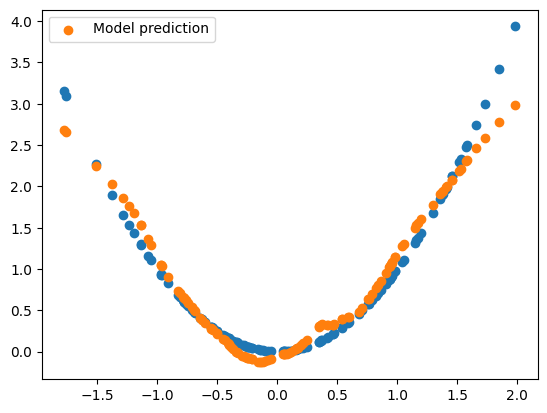

In [6]:
import matplotlib.pyplot as plt

def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):

  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

# key, _ = jax.random.split(key)
xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();